[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/abhiksark/gdg-paper-reading/blob/main/trainer.ipynb)

In [ ]:
!git clone https://github.com/gdg-raipur/paper-reading.git

In [2]:
%cd paper-reading
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar xf imagenette2-320.tgz

/content/paper-reading
--2023-03-25 15:25:07--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.46, 52.217.32.166, 3.5.19.157, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  12.9MB/s    in 27s     

2023-03-25 15:25:35 (12.2 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def find_lr(model, train_loader, criterion, device, optimizer, init_lr=1e-8, final_lr=10, beta=0.98):
    model.train()
    num_batches = len(train_loader)
    mult = (final_lr / init_lr) ** (1 / num_batches)
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr

    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    for inputs, labels in tqdm(train_loader, desc="Finding Learning Rate"):
        batch_num += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Update the learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

        # Record the loss and learning rate
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

    return log_lrs, losses

# Train the model
def train(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if scheduler:
            scheduler.step()

    return running_loss / len(dataloader), correct / total


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total
  
def visualize_kernels(model):
    # Get the weights of the first convolutional layer
    # first_conv_layer = model.features[0]
    kernels = model.conv1[0].weight.detach().cpu().numpy()

    # Normalize the weights to be between 0 and 1
    min_val = kernels.min()
    max_val = kernels.max()
    normalized_kernels = (kernels - min_val) / (max_val - min_val)

    # Plot the kernels
    num_kernels = normalized_kernels.shape[0]
    num_columns = 8
    num_rows = num_kernels // num_columns + int(num_kernels % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            kernel_img = normalized_kernels[i, :, :, :].transpose(1, 2, 0)
            ax.imshow(kernel_img)
        ax.axis("off")

    plt.show()

In [6]:
# Define data transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data using a DataLoader
train_set = ImageFolder('./imagenette2-320/train', transform=train_transform)
val_set = ImageFolder('./imagenette2-320/val', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)

In [7]:
from week_1.vgg13 import VGG13
from week_1.vgg16 import VGG16
from week_1.vgg19 import VGG19

In [24]:
# Define the model and move to device
model = VGG13(num_classes=10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Finding Learning Rate: 100%|██████████| 296/296 [02:19<00:00,  2.12it/s]


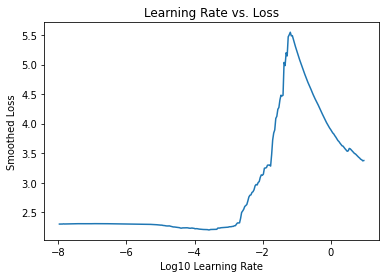

In [21]:
# Run the learning rate finder
log_lrs, losses = find_lr(model, train_loader, criterion, device, optimizer)

# Plot the learning rate vs. loss
plt.figure()
plt.plot(log_lrs, losses)
plt.xlabel("Log10 Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("Learning Rate vs. Loss")
plt.show()

In [25]:
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
# Main training and validation loop
num_epochs = 5
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Training:   0%|          | 0/296 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Validation: 100%|██████████| 123/123 [00:21<00:00,  5.70it/s]


Epoch 1, Train Loss: 2.1323, Train Acc: 0.2393, Val Loss: 1.8799, Val Acc: 0.3600


Validation: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]


Epoch 2, Train Loss: 1.9195, Train Acc: 0.3404, Val Loss: 1.6984, Val Acc: 0.4397


Validation: 100%|██████████| 123/123 [00:22<00:00,  5.47it/s]


Epoch 3, Train Loss: 1.8058, Train Acc: 0.3852, Val Loss: 1.5870, Val Acc: 0.4815


Validation: 100%|██████████| 123/123 [00:21<00:00,  5.74it/s]


Epoch 4, Train Loss: 1.7344, Train Acc: 0.4099, Val Loss: 1.5129, Val Acc: 0.5017


Validation: 100%|██████████| 123/123 [00:22<00:00,  5.45it/s]

Epoch 5, Train Loss: 1.6681, Train Acc: 0.4432, Val Loss: 1.4402, Val Acc: 0.5417


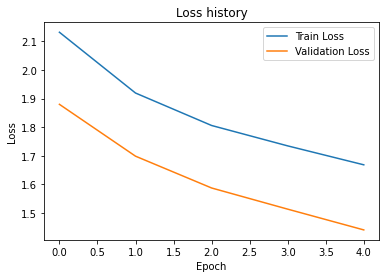

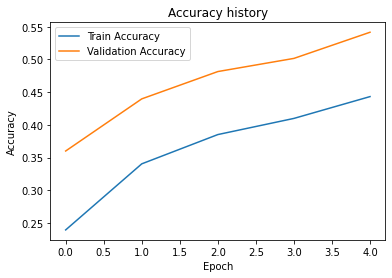

In [27]:
# Plotting the training and validation loss
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure()
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy history")
plt.legend()
plt.show()

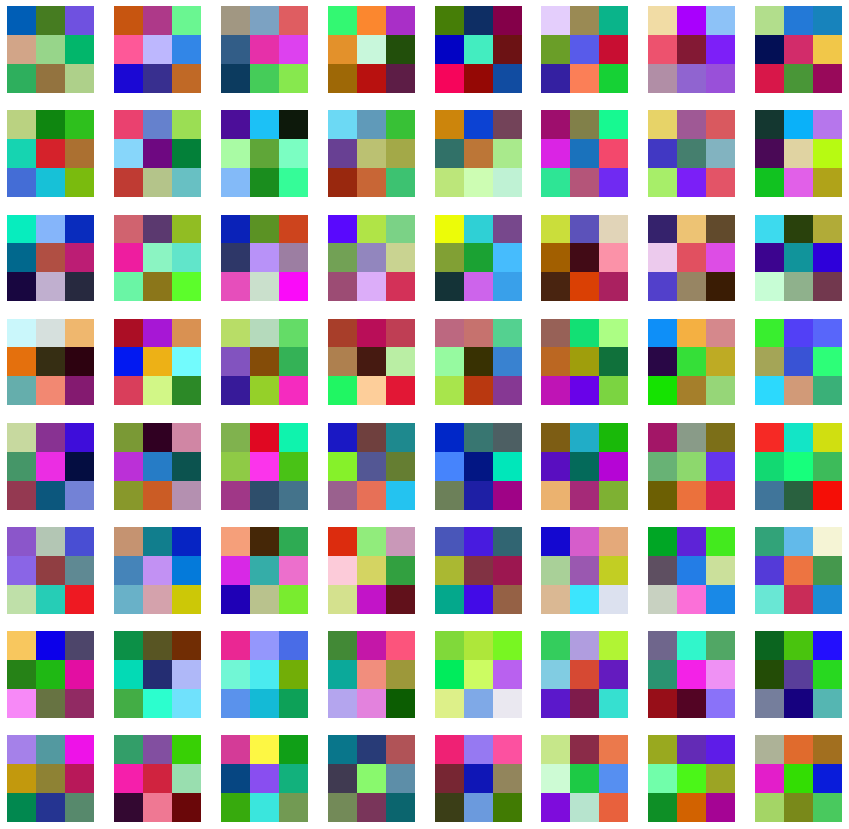

In [28]:
visualize_kernels(model)


In [29]:
# Get the weights of the first Conv2d layer in the conv5 block
weights = model.conv1[0].weight.detach().cpu()

In [30]:
import matplotlib.pyplot as plt

def plot_kernels(tensor, num_cols=8):
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(tensor[i][0], cmap='gray')  # Visualize the first channel of the kernel
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [31]:
weights = model.conv1[0].weight.detach().cpu()

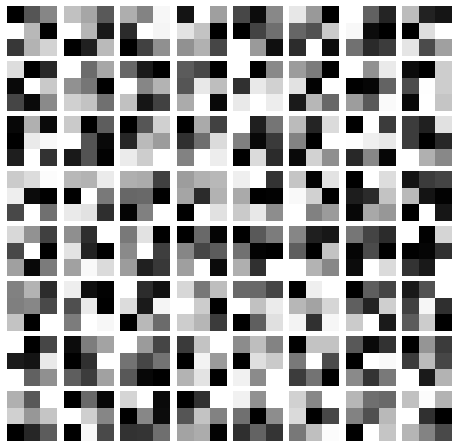

In [32]:
# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)


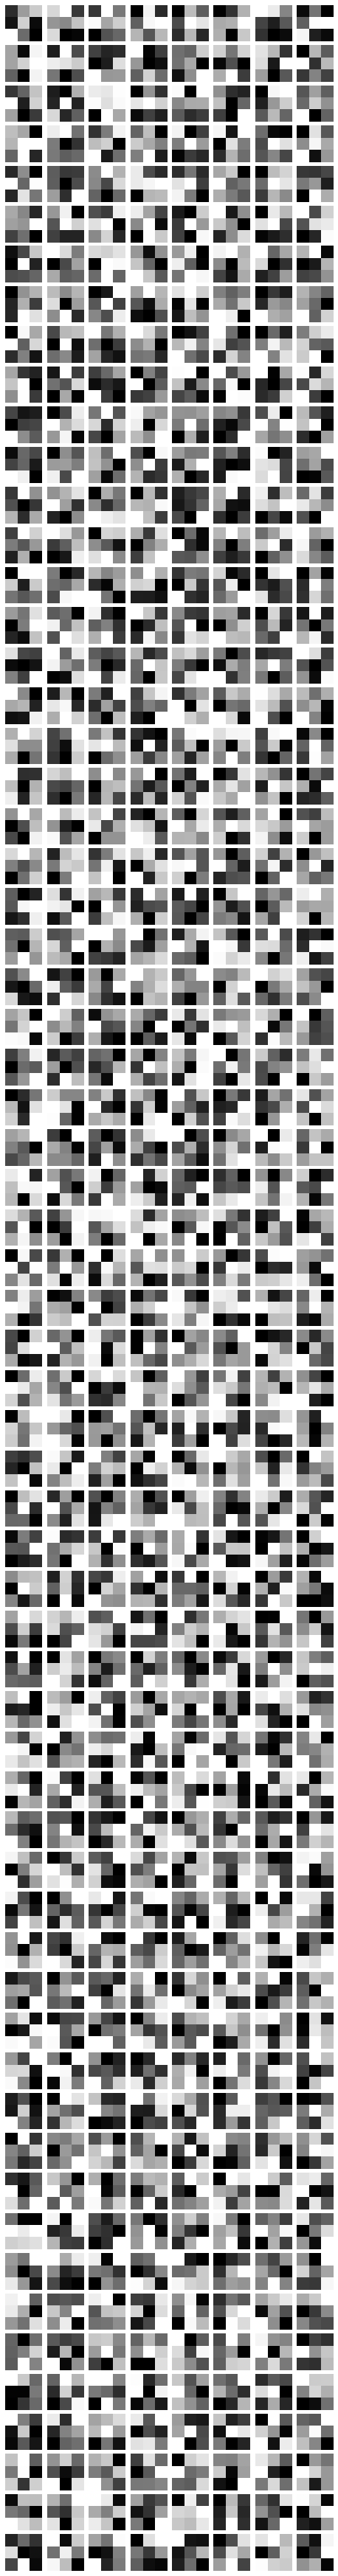

In [33]:
weights = model.conv5[0].weight.detach().cpu()

# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)
